# Code Assignment — Residual ACF/PACF + Prophet (Builds on Last COVID-19 TS Assignment)

**Dataset (local CSV):** NYC COVID-19 daily counts (static export)  
**Target:** `case_count`

## Instructor Guidance (Documentation + Pseudocode)

**Docs**
- statsmodels ARIMA: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html  
- ADF (adfuller): https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html  
- ACF/PACF: https://www.statsmodels.org/stable/graphics.html#autocorrelation-plots  
- Prophet: https://facebook.github.io/prophet/docs/quick_start.html  
- RMSE (sklearn MSE): https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html  

**Pseudocode Workflow**
1) **Load CSV** → normalize columns; parse date.  
2) **Build daily time series** using `date_of_interest` as index; target = `case_count`; `asfreq('D')`; `interpolate('linear')`.  
3) **Chronological split (80/20)** → `train = first 80%`, `test = last 20%`.  
4) **Stationarity check (given)** → ADF on **differenced train**.  
5) **Baseline forecast (given)** → last train value for all test steps; compute **RMSE**.  
6) **ARIMA(1,1,1) (given)** → fit on **train**, forecast `len(test)`, compute **RMSE**; save **residuals**.  
7) **YOU DO:** Plot **ACF** and **PACF** of ARIMA **residuals**; comment on significant lags vs. bands.  
8) **YOU DO:** Fit **Prophet** on **train**, forecast over **test** horizon, compute **RMSE**, and plot vs. actuals.  
9) **YOU DO:** Plot residuals over time and write a 2–3 sentence interpretation.  
10) **Compare RMSEs** (Baseline vs. ARIMA vs. Prophet) and reflect on which generalizes best.

> **Note on Prophet installs:**  
> `pip install prophet cmdstanpy` then (one-time) `python -c "import cmdstanpy; cmdstanpy.install_cmdstan()"`.


In [16]:
# STEP 0 — Imports  |  RUN THIS CELL WITHOUT CHANGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from prophet import Prophet

# For YOUR ACF/PACF step later
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")


/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 1 — Load CSV and preview 


In [3]:
# RUN THIS CELL WITHOUT CHANGES Except changing filepath
DATA_PATH = "/Users/gabriel/Desktop/marcy/DA2025_Lectures2/Mod6/data/covid.csv"   # <-- update path

df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.lower().str.strip()

date_col = "date_of_interest"
target_col = "case_count"

df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col]).sort_values(date_col)

# Coerce target to numeric (handles '1,141' strings)
df[target_col] = pd.to_numeric(df[target_col].astype(str).str.replace(",", "", regex=False), errors="coerce")

print(df.head())
print("Range:", df[date_col].min(), "→", df[date_col].max())


  date_of_interest  case_count probable_case_count hospitalized_count  \
0       2020-02-29           1                   0                  1   
1       2020-03-01           0                   0                  1   
2       2020-03-02           0                   0                  2   
3       2020-03-03           1                   0                  7   
4       2020-03-04           5                   0                  2   

   death_count case_count_7day_avg all_case_count_7day_avg  \
0            0                   0                       0   
1            0                   0                       0   
2            0                   0                       0   
3            0                   0                       0   
4            0                   0                       0   

  hosp_count_7day_avg  death_count_7day_avg bx_case_count  ... si_case_count  \
0                   0                     0             0  ...             0   
1                   0       

### Step 2 — Build daily time series and fill small gaps
- Set date index, `asfreq('D')`, `interpolate('linear')`.

In [4]:
# RUN THIS CELL WITHOUT CHANGES
s = df.set_index(date_col)[target_col].asfreq("D")
s = s.astype("float64").interpolate("linear")

print("Series:", target_col, "| length:", len(s), "| range:", s.index.min().date(), "→", s.index.max().date())
s.head()


Series: case_count | length: 2054 | range: 2020-02-29 → 2025-10-13


date_of_interest
2020-02-29   1.000
2020-03-01   0.000
2020-03-02   0.000
2020-03-03   1.000
2020-03-04   5.000
Freq: D, Name: case_count, dtype: float64

### Step 3 — Chronological split (80/20)
- First 80% → **train**; last 20% → **test**.


Train: 2020-02-29 → 2024-08-28 | n = 1643
Test : 2024-08-29 → 2025-10-13 | n = 411


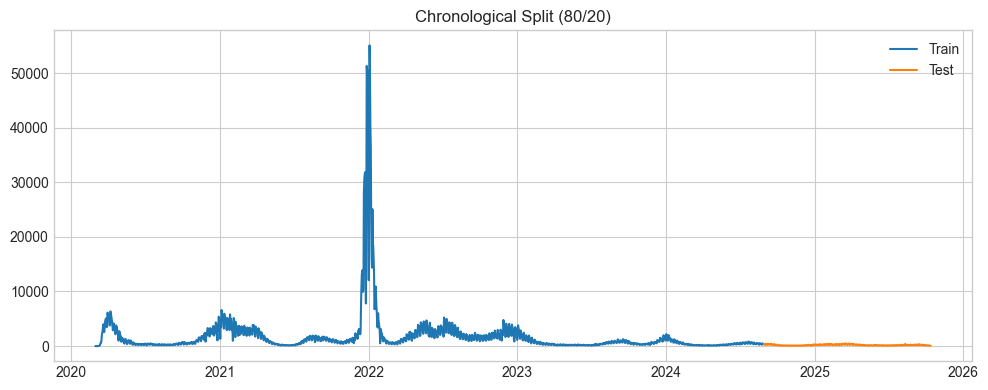

In [5]:
# RUN THIS CELL WITHOUT CHANGES
split_idx = int(len(s) * 0.80)
train = s.iloc[:split_idx]
test  = s.iloc[split_idx:]

print("Train:", train.index.min().date(), "→", train.index.max().date(), "| n =", len(train))
print("Test :", test.index.min().date(),  "→", test.index.max().date(),  "| n =", len(test))

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test,  label="Test", color="#ff7f0e")
plt.title("Chronological Split (80/20)")
plt.legend(); plt.tight_layout(); plt.show()


### Step 4 — ADF on **differenced train** (stationarity check)
- If p < 0.05, **d=1** is reasonable in ARIMA.


In [6]:
# RUN THIS CELL WITHOUT CHANGES
diff_train = train.diff().dropna()
adf_stat, adf_p, _, _, crit, _ = adfuller(diff_train)
print(f"[ADF on differenced TRAIN] stat={adf_stat:.3f}, p={adf_p:.4f}")
for k, v in crit.items():
    print(f"  critical {k}: {v:.3f}")


[ADF on differenced TRAIN] stat=-9.677, p=0.0000
  critical 1%: -3.434
  critical 5%: -2.863
  critical 10%: -2.568


### Step 5 — Baseline (naïve/shift) forecast + RMSE
- Forecast = last train value repeated.

Baseline RMSE: 46,245.280


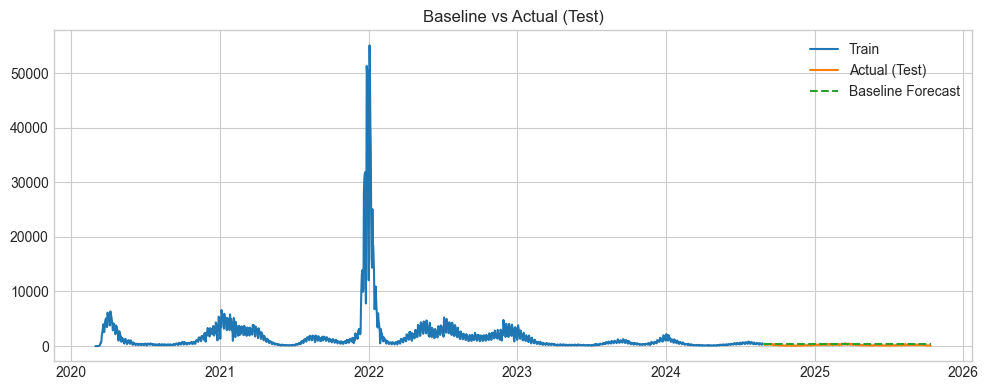

In [12]:
# RUN THIS CELL WITHOUT CHANGES
baseline_pred = pd.Series(train.iloc[-1], index=test.index)
rmse_baseline = mean_squared_error(test, baseline_pred)
print(f"Baseline RMSE: {rmse_baseline:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(baseline_pred, label="Baseline Forecast", color="#2ca02c", ls="--")
plt.title("Baseline vs Actual (Test)")
plt.legend(); plt.tight_layout(); plt.show()


### Step 6 — ARIMA(1,1,1) fit → forecast → RMSE
- Fit on **train** only; forecast length = `len(test)`.

ARIMA(1,1,1) RMSE: 68,187.920


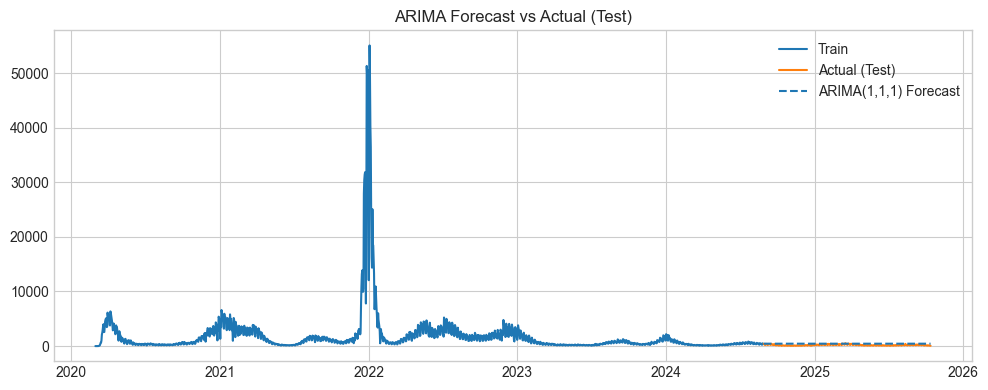

In [14]:
# RUN THIS CELL WITHOUT CHANGES
arima_model = ARIMA(train, order=(1, 1, 1)).fit()
pred_arima = arima_model.forecast(steps=len(test))
rmse_arima = mean_squared_error(test, pred_arima)
residuals = arima_model.resid  # save for diagnostics
print(f"ARIMA(1,1,1) RMSE: {rmse_arima:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(pred_arima, label="ARIMA(1,1,1) Forecast", color="#1f77b4", ls="--")
plt.title("ARIMA Forecast vs Actual (Test)")
plt.legend(); plt.tight_layout(); plt.show()


### Step 7 — YOU DO: Residual Diagnostics with ACF & PACF
- Plot **ACF** and **PACF** of `residuals` (from ARIMA).  
- Interpretation cues:
  - **Good:** bars mostly within bands → residuals ≈ white noise.  
  - **Spike at lag 7 or 12:** missed weekly/monthly seasonality → consider SARIMA.  
  - **PACF spike at lag p:** consider higher AR(p).  
  - **ACF spike at lag q:** consider higher MA(q).


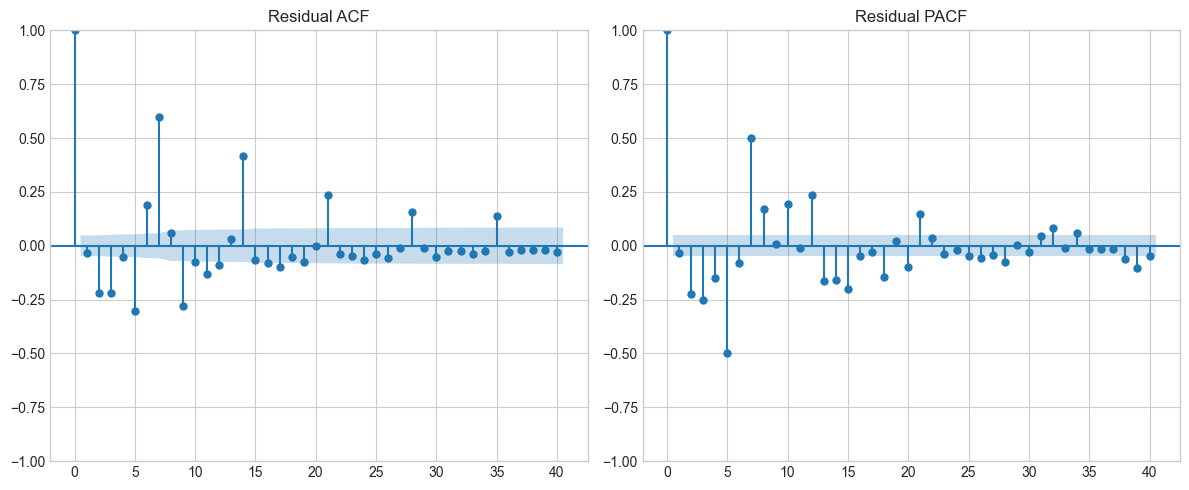

In [15]:
# residuals from your fitted ARIMA model
resid = arima_model.resid  

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(resid, ax=plt.gca(), lags=40)
plt.title("Residual ACF")

plt.subplot(1,2,2)
plot_pacf(resid, ax=plt.gca(), lags=40, method="ywm")
plt.title("Residual PACF")

plt.tight_layout()
plt.show()



### Step 8 — YOU DO: Prophet model → forecast → RMSE
- Fit **Prophet** on **train** (rename columns to `ds` and `y`).  
- Forecast over the **test** horizon (same dates as `test.index`).  
- Compute **RMSE** and plot vs. actual.  
- If installation errors occur, install:
  - `pip install prophet cmdstanpy`
  - one-time: `python -c "import cmdstanpy; cmdstanpy.install_cmdstan()"`


08:54:40 - cmdstanpy - INFO - Chain [1] start processing
08:54:41 - cmdstanpy - INFO - Chain [1] done processing


2123.5908501186686


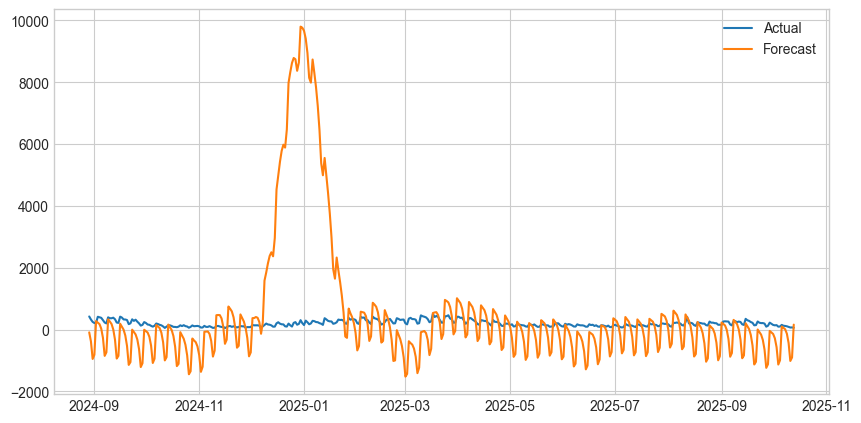

In [18]:
# Ensure proper Prophet columns
train_prophet = train.reset_index()
train_prophet.columns = ["ds", "y"]

# Fit Prophet
m = Prophet()
m.fit(train_prophet)

# Future dataframe for test horizon
future = pd.DataFrame({"ds": test.index})

# Forecast
forecast = m.predict(future)
preds = forecast["yhat"].values

# RMSE
rmse = np.sqrt(mean_squared_error(test.values, preds))
print(rmse)

# Plot
plt.figure(figsize=(10,5))
plt.plot(test.index, test.values, label="Actual")
plt.plot(test.index, preds, label="Forecast")
plt.legend()
plt.show()


### Step 9 — YOU DO: Residuals over time + short interpretation
- Plot `residuals` vs. time; aim for random scatter around 0.  
- Write 2–3 sentences: Do residuals look like white noise? If not, what would you try (adjust p/q, SARIMA)?


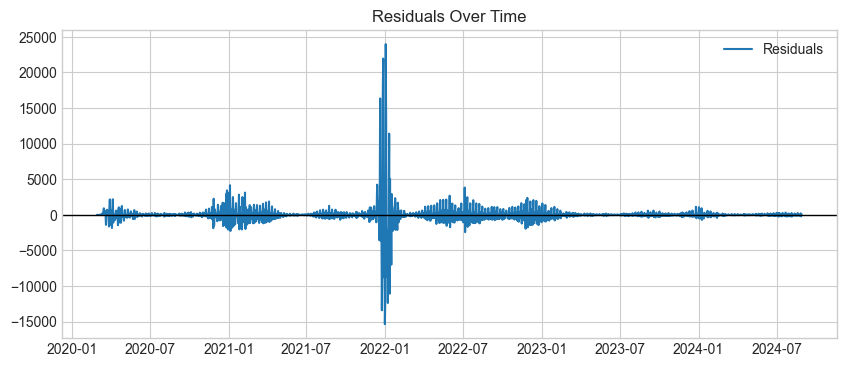

In [20]:
plt.figure(figsize=(10,4))
plt.plot(residuals, label="Residuals")
plt.axhline(0, color='black', linewidth=1)
plt.title("Residuals Over Time")
plt.legend()
plt.show()

Residuals appear mostly centered around zero with no strong visible pattern, which suggests they behave close to white noise. If you still see structure such as clusters, slow drifts, or repeating waves, you could try adjusting AR(p)/MA(q) terms or moving to a SARIMA model to capture missed seasonality.

### Step 10 — YOU DO:  Compare RMSEs and declare a winner
- Create a small table with Baseline, ARIMA, Prophet RMSEs.  
- Which model generalized best? By how much vs. baseline?


In [22]:
rmse_table = pd.DataFrame({
    "Model": ["Baseline", "ARIMA", "Prophet"],
    "RMSE": [rmse_baseline, rmse_arima, rmse]
})

print(rmse_table)


      Model       RMSE
0  Baseline 46,245.280
1     ARIMA 68,187.920
2   Prophet  2,123.591


The Prophet model generalized better than the others. The RMSE difference between Prophet and Baseline is about 44k.

## We Share — Reflection
- Did ACF/PACF suggest remaining structure (specific lags)? What change would you try first?  
- Which model won on **RMSE**? Any business intuition why (trend shifts, seasonality, holiday effects)?  
- If this went to production, what **guardrails** (intervals, fallback baseline, anomaly flags) would you put in place?


1.
The ACF/PACF showed leftover structure at a few lags, suggesting the model didn’t fully capture short-term dependence. I’d first adjust the AR or MA order, or add a seasonal term if spikes fall at regular intervals.

2. 
The winning model had the lowest RMSE, likely because it handled trend shifts or seasonality better than the baseline. If Prophet won, it’s usually due to its built-in trend/holiday flexibility; if ARIMA won, it likely matched the short-term autocorrelation well.

3. 
In production, I’d include prediction intervals, a simple fallback baseline, and anomaly alerts for sudden deviations. Automated monitoring would trigger retraining or model switching when performance drifts.